### LeNet-5 실습 02

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from datetime import datetime
from torchvision import datasets, transforms

In [2]:
# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(f"Device : {device}")

Device : cpu


#### Hyper parameters

In [3]:
RANDOM_SEED = 777
lr = 0.001
batch_size = 32
number_epochs = 20

IMG_SIZE = 32
class_number = 10 # MNIST 데이터셋 0 ~ 9 : 10개의 클래스

#### Transforms 정의

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])


#### Dataset, Dataloader

In [5]:
train_dataset = MNIST(root='./data',
                      train=True,
                      transform=train_transform,
                      download=True)

test_dataset = MNIST(root='./data',
                      train=False,
                      transform=test_transform,
                      download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

C:\Users\Jay\AppData\Local\Temp\ipykernel_23240\1254514758.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


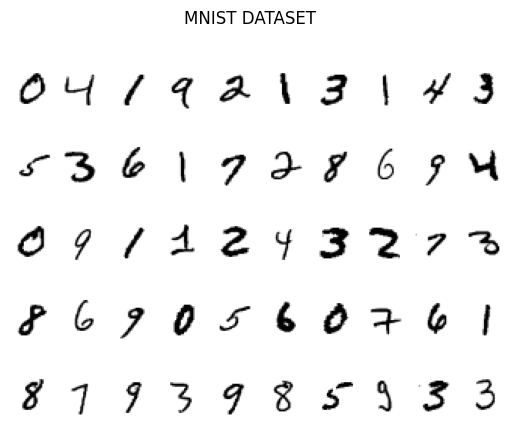

In [6]:
ROW_IMG = 10 
N_ROWS = 5
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1) :
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle("MNIST DATASET")
fig.show()

In [7]:
class LeNet5(nn.Module) :
    def __init__(self, class_number) :
        super(LeNet5, self).__init__()
        """
        Lenet-5 네트워크의 피쳐 추출 부분
        """
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1), # (32, 6, 높이, 너비)
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # (32, 6, 높이/2, 너비/2) : Feature map 크기가 절반이됨
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), # (32, 16, 높이/2, 너비/2)
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # # (32, 16, 높이/2, 너비/2) -> (32, 16, 높이/4, 너비/4) : Feature map 크기가 절반이됨
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1), # # (32, 120, 높이/4, 너비/4) : 최종 Feature map 크기
            nn.Tanh(),
        )
        """
        Lenet-5 모델의 분류기 부분
        Lenet-5 네트워크의 피쳐 추출 부분 -> out_channels=120 -> in_features=120 -> 84 (특성 차원 축소) 
        -> 클래스 개수에 대한 로짓을 출력 -> 소프트 맥스 함수 -> 클래스별 확률로 변환
        """
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=class_number)
        )
    
    def forward(self, x) :
        x = self.feature_extractor(x)    # 입력 이미지 : 특성 추출 과정
        x = torch.flatten(x,1)           # flatten() : 1차원으로 펼쳐주는 과정
        logits = self.classifier(x)      # 클래스별 로짓값
        probs = F.softmax(logits, dim=1) # 클래스별 확률값
        return logits, probs

#### Accuracy 구하는 함수 구현

In [8]:
def get_acc(model, data_loader, device) :
    """
    전체 data_loader에 대한 예측 정확도를 계산하는 함수
    """
    correct_pred = 0 
    n = 0
    model.eval()

    with torch.no_grad() :
        for x, y_true in data_loader :
            x = x.to(device)
            y = y_true.to(device)
            _, y_prob = model(x)
            _, predicted_labels = torch.max(y_prob, 1)
            n += y.size(0)
            correct_pred += (predicted_labels == y).sum()
    return correct_pred.float() / n

In [9]:
def train(train_loader, model, criterion, optimizer, device) :
    """
    training loop의 train 단계에 대한 함수
    """
    model.train()
    running_loss = 0 
    
    for x, y in train_loader :
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        # 순전파
        y_hat, _ = model(x) # model(x) -> 예측값, 확률값
        loss = criterion(y_hat, y)
        running_loss += loss.item() * x.size(0) # 배치사이즈 만큼 처리를 위한 임시 변수 

        # 역전파
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset) # 평균 손실계산
    return model, optimizer, epoch_loss

In [10]:
def validate(valid_loader, model, criterion, device) :
    """
    training loop의 validation 단계에 대한 함수
    """
    model.eval()
    running_loss = 0 
    
    for x, y_true in valid_loader :
        x = x.to(device)
        y = y_true.to(device)

        # 순전파와 손실 기록
        y_hat, _ = model(x)
        loss = criterion(y_hat, y)
        running_loss += loss.item() * x.size(0)
    
    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss

#### 학습 loop

In [11]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, pring_every=1) :
    train_losses = []
    valid_losses = []

    # model 학습
    for epoch in range(0, epochs) :
        # train
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad() :
            model, valid_loss = validate(test_loader, model, criterion, device)
            valid_losses.append(valid_loss)
        
        if epoch % pring_every == (pring_every - 1) :
            train_acc = get_acc(model, train_loader, device)
            valid_acc = get_acc(model, test_loader, device)
            print(f"{datetime.now().time().replace(microsecond=0)} \n" +
                  f"Epoch : {epoch+1}\n" +
                  f"Train loss : {train_loss:.4f}\n" +
                  f"Valid loss : {valid_loss:.4f}\n" +
                  f"Train acc : {100 * train_acc:.2f}\n" +
                  f"Valid acc : {100 * valid_acc:.2f}\n")
    return model, optimizer, (train_losses, valid_losses)

In [12]:
torch.manual_seed(RANDOM_SEED)
model = LeNet5(class_number).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, test_loader, class_number, device)

15:53:29 
Epoch : 1
Train loss : 0.2174
Valid loss : 0.0820
Train acc : 97.56
Valid acc : 97.54

15:53:51 
Epoch : 2
Train loss : 0.0768
Valid loss : 0.0546
Train acc : 98.56
Valid acc : 98.22

15:54:14 
Epoch : 3
Train loss : 0.0540
Valid loss : 0.0575
Train acc : 98.51
Valid acc : 98.14

15:54:36 
Epoch : 4
Train loss : 0.0419
Valid loss : 0.0442
Train acc : 99.24
Valid acc : 98.65

15:54:59 
Epoch : 5
Train loss : 0.0357
Valid loss : 0.0496
Train acc : 99.19
Valid acc : 98.52

15:55:22 
Epoch : 6
Train loss : 0.0285
Valid loss : 0.0460
Train acc : 99.26
Valid acc : 98.59

15:55:45 
Epoch : 7
Train loss : 0.0261
Valid loss : 0.0478
Train acc : 99.30
Valid acc : 98.40

15:56:08 
Epoch : 8
Train loss : 0.0215
Valid loss : 0.0630
Train acc : 99.07
Valid acc : 98.17

15:56:30 
Epoch : 9
Train loss : 0.0193
Valid loss : 0.0444
Train acc : 99.59
Valid acc : 98.69

15:56:52 
Epoch : 10
Train loss : 0.0168
Valid loss : 0.0425
Train acc : 99.58
Valid acc : 98.68

